In [14]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator,  get_number_preserving_sparse_operator


In [15]:
def indices_with_N_and_Sz0(n_orbital, n_elec):
    """전자수=N 이면서 S_z=0 (interleaved: 짝수=alpha, 홀수=beta)"""
    idx = []
    for s in range(1 << n_orbital):
        if s.bit_count() != n_elec:
            continue
        n_alpha = sum((s >> i) & 1 for i in range(0, n_orbital, 2))  # 0,2,4,...
        n_beta  = sum((s >> i) & 1 for i in range(1, n_orbital, 2))  # 1,3,5,...
        if n_alpha == n_beta:
            idx.append(s)
    return np.array(idx, dtype=int)

def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [16]:
def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

import numpy as np
import matplotlib.pyplot as plt

def plot_points_and_line(a, b, y_line, title="compare Full Diag. and GBBD"):
    a = np.asarray(a).ravel()
    b = np.asarray(b).ravel()
    y_line = np.asarray(y_line).ravel()
    L = a.size + b.size

    # 검증
    if y_line.size != L:
        raise ValueError(f"y_line 길이({y_line.size})가 a+b({L})와 다릅니다.")

    # a,b 합치고 라벨 (a=0, b=1)
    vals = np.concatenate([a, b])
    labels = np.concatenate([np.zeros_like(a, dtype=int),
                             np.ones_like(b, dtype=int)])

    # 오름차순 정렬 (안정 정렬로 tie 처리)
    idx = np.argsort(vals, kind='mergesort')
    y_pts = vals[idx]
    lab_sorted = labels[idx]

    # x축: 1..L
    x = np.arange(1, L + 1)

    plt.figure(figsize=(8, 4.8))

    # 1) 길이 L 데이터로 선(검은색)
    plt.plot(x, y_line, '-k', ls='--', label='Full matrix Digonaliztion')

    # 2) 점: a=빨강, b=파랑 (정렬된 순서대로 배치)
    a_mask = (lab_sorted == 0)
    b_mask = ~a_mask
    plt.scatter(x[a_mask], y_pts[a_mask], c='red', s=40, label='Biggest block')
    plt.scatter(x[b_mask], y_pts[b_mask], c='blue', s=40, label='Second Biggest block')

    plt.ylabel("Eigen Value")
    plt.title(title)
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

### 행렬만들기

In [17]:
dist = 1.322
geometry = [('H', (0., 0., 0.)),
            ('H', (0., 0., 0.7414 ))]
# geometry = [("Co", Co),
#             ("O", O_1),
#             ("O", O_2),
#             ("Li", Li)]  # Angstrom

basis = 'sto-3g'
mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
mol = run_pyscf(mol, run_scf=1, run_fci=0)
# 3. 2차 정량화 Hamiltonian 얻기
ham_int = mol.get_molecular_hamiltonian()
ham_fci = get_fermion_operator(ham_int)     
#H = get_sparse_operator(ham_fci, n_qubits=mol.n_qubits)
H = get_number_preserving_sparse_operator(
fermion_op=ham_fci,
num_qubits=mol.n_qubits,
num_electrons=mol.n_electrons,       # 필수
spin_preserving=True ,        # S_z 고정 (필요 없으면 None)
reference_determinant=None,
excitation_level=None)
print(H)
H_real = H.real

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	-1.1166843870853407
  (3, 0)	0.18128880821149593
  (1, 1)	-0.3511901986746764
  (2, 1)	-0.18128880821149593
  (1, 2)	-0.18128880821149593
  (2, 2)	-0.3511901986746764
  (0, 3)	0.18128880821149593
  (3, 3)	0.4592503306687161


In [18]:
print(H_real)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	-1.1166843870853407
  (3, 0)	0.18128880821149593
  (1, 1)	-0.3511901986746764
  (2, 1)	-0.18128880821149593
  (1, 2)	-0.18128880821149593
  (2, 2)	-0.3511901986746764
  (0, 3)	0.18128880821149593
  (3, 3)	0.4592503306687161


In [19]:
H_test = H_real.toarray()
w = np.linalg.eigvals(H_test)   # 고유값만 반환
print(np.sort(w))                   # array([...])

[-1.13727017 -0.53247901 -0.16990139  0.47983612]


### 행렬 히트맵 확인용

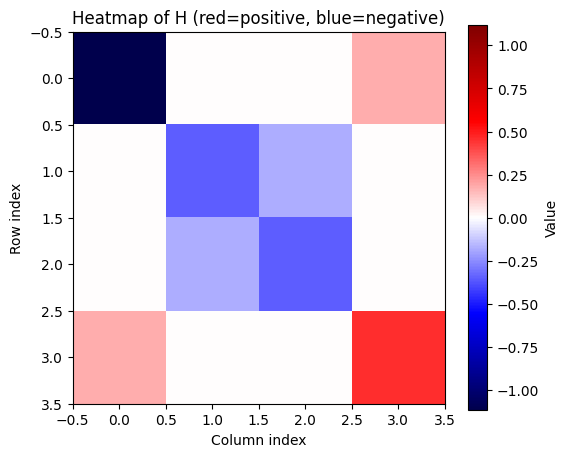

In [20]:
H_dense = H_real.toarray()
# 2) 히트맵 그리기
plt.figure(figsize=(6,5))

# 값 크기에 맞게 대칭적인 색범위 설정
vmax = np.abs(H_dense).max()

im = plt.imshow(H_dense, cmap='seismic', vmin=-vmax, vmax=vmax)
plt.colorbar(im, label="Value")

plt.title("Heatmap of H (red=positive, blue=negative)")
plt.xlabel("Column index")
plt.ylabel("Row index")
plt.show()

### 그래프 표현(무향)

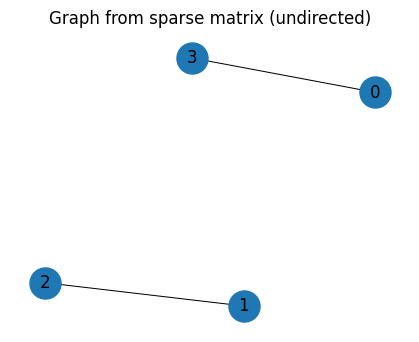

In [21]:
G = sparse_to_graph(H_real, directed=False, weight="abs", symmetrize=True, tol=0.0)
ccs = list(nx.connected_components(G))

subgraphs = [G.subgraph(S).copy() for S in ccs]

pos = nx.spring_layout(G, seed=0)
edge_w = [d["weight"] for *_, d in G.edges(data=True)]

plt.figure(figsize=(4,3))
nx.draw(G, pos, with_labels=True, node_size=500, width=edge_w)  # weight를 두께로
plt.title("Graph from sparse matrix (undirected)")
plt.show()

### 에너지 계산

In [22]:
sub_mat_idx_g = list(ccs[0])
H_sub_g = H[sub_mat_idx_g, :][:, sub_mat_idx_g]
print(H_sub_g)
H_test_g = H_sub_g.toarray()
e_g = np.linalg.eigvals(H_test_g)   # 고유값만 반환
print(e_g)                   # array([...])

sub_mat_idx_e = list(ccs[1])
H_sub_e = H[sub_mat_idx_e, :][:, sub_mat_idx_e]
print(H_sub_e)
H_test_e = H_sub_e.toarray()
e_e = np.linalg.eigvals(H_test_e)   # 고유값만 반환
print(e_g)      

print("Ground_state_Energy : ", e_g)
print("1st_Excited_Energy : ", e_e)

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	-1.1166843870853407
  (1, 0)	0.18128880821149593
  (0, 1)	0.18128880821149593
  (1, 1)	0.4592503306687161
[-1.13727017  0.47983612]
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	-0.3511901986746764
  (1, 0)	-0.18128880821149593
  (0, 1)	-0.18128880821149593
  (1, 1)	-0.3511901986746764
[-1.13727017  0.47983612]
Ground_state_Energy :  [-1.13727017  0.47983612]
1st_Excited_Energy :  [-0.16990139 -0.53247901]


/var/folders/mq/vvzpq4_16092g__xg10fscp80000gn/T/ipykernel_12234/3738821342.py:123: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-k" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(x, y_line, '-k', ls='--', label='Full matrix Digonaliztion')


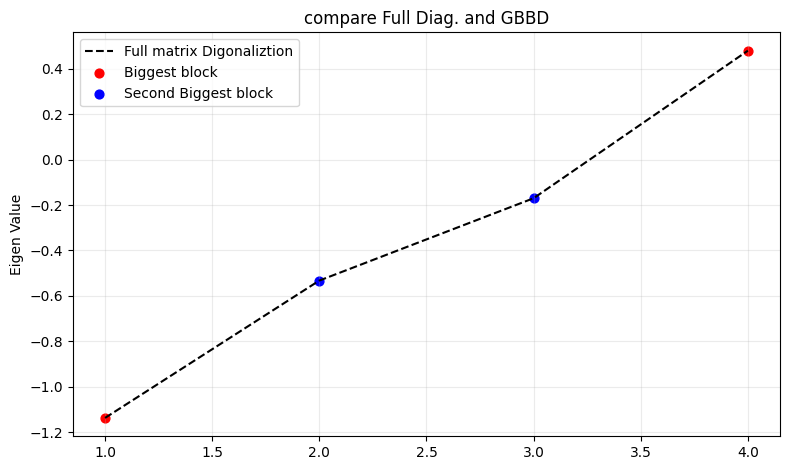

In [23]:
a = e_g   # 길이 a
b = e_e  # 길이 b
y_line = np.sort(w)
plot_points_and_line(a, b, y_line)